TO DO:
- Export cleaned data to CSV
- Duplicate check!
- Import to PGAdmin
- Create Host Table (either in Python or SQL)
- Create Booking Fact Table
- Create Success Fact Table
- Create other dimension
- Check Normalization (not thoroughly)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

calendar_df = pd.read_csv('calendar2024.csv')
listings_df = pd.read_csv('listings2024.csv')
reviews_df = pd.read_csv('reviews2024.csv')

In [39]:
# count of rows and columns
print(listings_df.shape)
print(reviews_df. shape)
print(calendar_df. shape)

(20909, 75)
(366636, 6)
(7631731, 7)


# Listings

In [40]:
#Removing columns with no data
threshold = len(listings_df)
listings_df = listings_df.loc[:, listings_df.isnull().sum() < threshold]

listings_df.info()
listings_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20909 entries, 0 to 20908
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20909 non-null  int64  
 1   listing_url                                   20909 non-null  object 
 2   scrape_id                                     20909 non-null  int64  
 3   last_scraped                                  20909 non-null  object 
 4   source                                        20909 non-null  object 
 5   name                                          20909 non-null  object 
 6   description                                   20235 non-null  object 
 7   neighborhood_overview                         8984 non-null   object 
 8   picture_url                                   20909 non-null  object 
 9   host_id                                       20909 non-null 

(20909, 72)

In [41]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20909 entries, 0 to 20908
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20909 non-null  int64  
 1   listing_url                                   20909 non-null  object 
 2   scrape_id                                     20909 non-null  int64  
 3   last_scraped                                  20909 non-null  object 
 4   source                                        20909 non-null  object 
 5   name                                          20909 non-null  object 
 6   description                                   20235 non-null  object 
 7   neighborhood_overview                         8984 non-null   object 
 8   picture_url                                   20909 non-null  object 
 9   host_id                                       20909 non-null 

## Correcting formats

In [42]:
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Rename the column to 'price_dkk'
listings_df.rename(columns={'price': 'price_dkk'}, inplace=True)

#converting rate from object to floats
columns_to_convert = ['host_response_rate', 'host_acceptance_rate']

for column in columns_to_convert:
        # Remove '%' and convert to float
        listings_df[column] = listings_df[column].str.replace('%', '').astype(float) / 10
        
# Rename the column to 'listing_id for readability in start schema'
listings_df.rename(columns={'id': 'listing_id'}, inplace=True)

## Simplifying qualitative information

In [43]:
listings_df.drop(columns=['bathrooms'], inplace=True)

listings_df['number_of_bathrooms'] = None
listings_df['type_of_bathroom'] = None

listings_df.loc[listings_df['bathrooms_text'].isnull(), ['number_of_bathrooms', 'type_of_bathroom']] = None

listings_df['number_of_bathrooms'] = listings_df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)

listings_df.loc[listings_df['number_of_bathrooms'].isnull() & listings_df['bathrooms_text'].str.contains('bath', case=False, na=False), 'number_of_bathrooms'] = 0.5

listings_df['type_of_bathroom'] = listings_df['bathrooms_text'].apply(lambda x: 'shared' if isinstance(x, str) and 'shared' in x.lower() else 'private' if isinstance(x, str) else None
    )
    

In [44]:
# Quantifying reviews 
listings_df['description_format'] = listings_df['description'].apply(lambda x: 
        'short' if len(str(x)) < 100 else
        'medium' if 100 <= len(str(x)) <= 500 else
        'long')
listings_df.drop(columns=['description'], inplace=True)

In [45]:
# Quantifying neighborhood_overview
listings_df['neighborhood_overview_format'] = listings_df['neighborhood_overview'].apply(lambda x: 
        'short' if len(str(x)) < 100 else
        'medium' if 100 <= len(str(x)) <= 500 else
        'long')
listings_df.drop(columns=['neighborhood_overview'], inplace=True)


In [46]:
#Quantifying host_about
listings_df['host_about_format'] = listings_df['host_about'].apply(lambda x: 
        'short' if len(str(x)) < 100 else
        'medium' if 100 <= len(str(x)) <= 500 else
        'long')
listings_df.drop(columns=['host_about'], inplace=True)

In [47]:
print(listings_df['description_format'].value_counts())
print(listings_df['neighborhood_overview_format'].value_counts())
print(listings_df['host_about_format'].value_counts())

medium    13861
long       5316
short      1732
Name: description_format, dtype: int64
short     13404
medium     5478
long       2027
Name: neighborhood_overview_format, dtype: int64
short     14489
medium     5858
long        562
Name: host_about_format, dtype: int64


In [48]:
#amount of ammenites includes/listed
def count_amenities(amenities_str):
    try:
        # Convert the string to an actual list
        amenities_list = ast.literal_eval(amenities_str)
        return len(amenities_list)
    except:
        # If the string is not valid or is NaN, return 0
        return 0

listings_df['num_amenities'] = listings_df['amenities'].apply(count_amenities)

In [49]:
listings_df.shape

(20909, 74)

## OUTLIERS


In [50]:
print(listings_df['price_dkk'].max())
print(listings_df['calculated_host_listings_count'].max())

print(listings_df[listings_df['calculated_host_listings_count'] > 20].shape[0])
print(listings_df[listings_df['price_dkk'] > 20000].shape[0])



100000.0
239
436
4


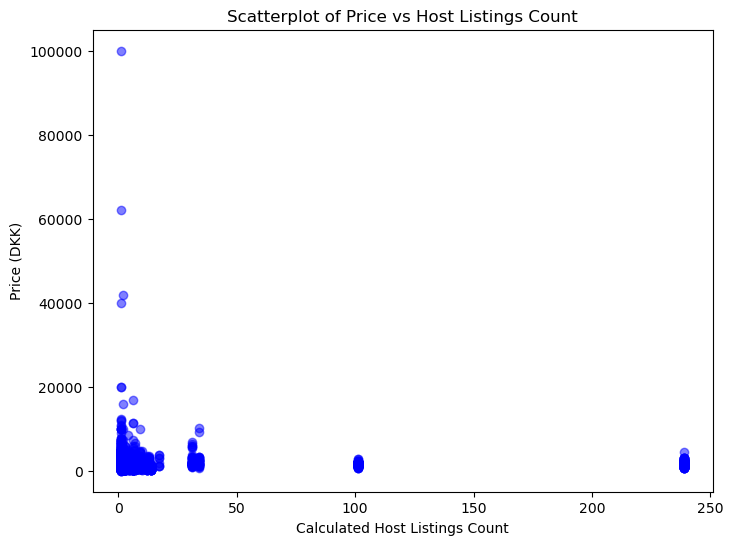

In [51]:
# Scatterplot for 'price_dkk' vs 'calculated_host_listings_count'
plt.figure(figsize=(8, 6))  
plt.scatter(listings_df['calculated_host_listings_count'], listings_df['price_dkk'], alpha=0.5, color='blue')

plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Price (DKK)')
plt.title('Scatterplot of Price vs Host Listings Count')

plt.show()

In [52]:
listings_df = listings_df[
    (listings_df['price_dkk'] <= int(20000)) & (listings_df['calculated_host_listings_count'] <= int(50))
    ]

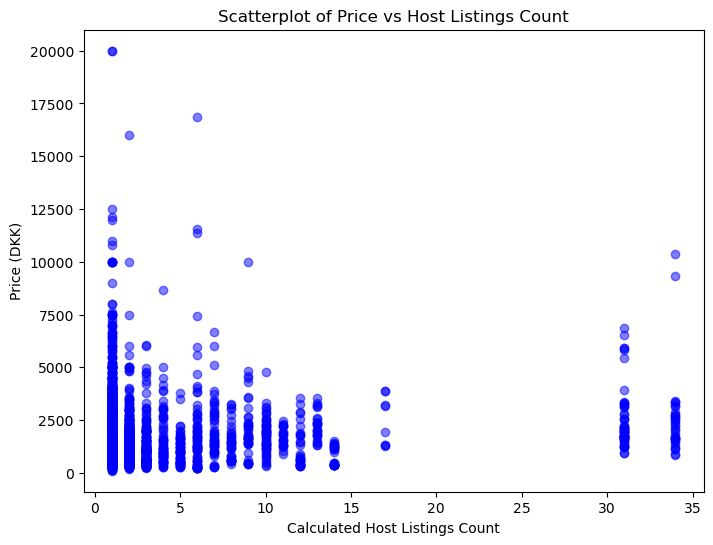

In [53]:
# Scatterplot for 'price_dkk' vs 'calculated_host_listings_count'
plt.figure(figsize=(8, 6)) 
plt.scatter(listings_df['calculated_host_listings_count'], listings_df['price_dkk'], alpha=0.5, color='blue')

plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Price (DKK)')
plt.title('Scatterplot of Price vs Host Listings Count')


plt.show()

In [54]:
listings_df = listings_df[
    (listings_df['price_dkk'] <= int(12500)) & (listings_df['calculated_host_listings_count'] <= int(15))
    ]

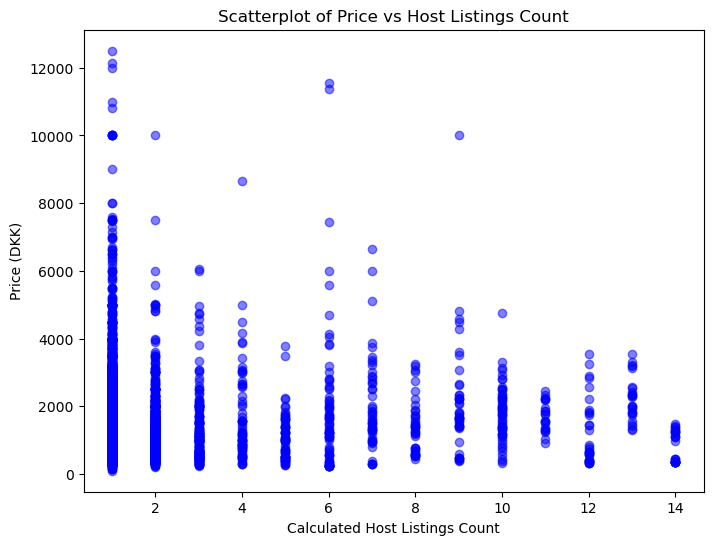

In [55]:
# Scatterplot for 'price_dkk' vs 'calculated_host_listings_count'
plt.figure(figsize=(8, 6))  
plt.scatter(listings_df['calculated_host_listings_count'], listings_df['price_dkk'], alpha=0.5, color='blue')


plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Price (DKK)')
plt.title('Scatterplot of Price vs Host Listings Count')

plt.show()

In [56]:
print(listings_df['price_dkk'].max())
print(listings_df['calculated_host_listings_count'].max())

12500.0
14


In [57]:
listings_df.shape

(13148, 74)

## Remove inactive listings

In [58]:
listings_df["last_review"] = pd.to_datetime(listings_df["last_review"], errors="coerce")

inactive_listing_ids = []

for index, row in listings_df.iterrows():
    if (
        row["availability_365"] == 0 and
        (
            row["number_of_reviews"] == 0 or
            row["last_review"] < pd.Timestamp("2021-01-01")
        )
    ):
        inactive_listing_ids.append(row["listing_id"])

listings_df = listings_df.loc[~listings_df["listing_id"].isin(inactive_listing_ids)]

calendar_df = calendar_df.loc[~calendar_df["listing_id"].isin(inactive_listing_ids)]

print("Updated listings_df shape:", listings_df.shape)
len(inactive_listing_ids)

Updated listings_df shape: (13120, 74)


28

## Location corrections


Street Name text Street name of the listing.
House Number text House number of the listing.
Zip Code integer Zip code of the listing.
Area text Area of the listing.
City text City of the listing.

In [59]:
# Set up the Google Maps API client (replace 'your_api_key' with your actual API key)
gmaps = googlemaps.Client(key='your_api_key')

# Filter the rows where both 'latitude' and 'longitude' are non-null
data_non_null = data.dropna(subset=['latitude', 'longitude'])

# Function to perform reverse geocoding and extract the neighborhood
def get_neighborhood(lat, lng):
    try:
        # Perform reverse geocoding
        reverse_geocode_result = gmaps.reverse_geocode((lat, lng))
        
        # Loop through the results and look for the neighborhood in the address components
        for result in reverse_geocode_result:
            for component in result['address_components']:
                if 'neighborhood' in component['types']:
                    return component['long_name']
        return None  # Return None if neighborhood is not found
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# Apply reverse geocoding to the non-null latitude and longitude rows
data_non_null['neighborhood'] = data_non_null.apply(lambda row: get_neighborhood(row['latitude'], row['longitude']), axis=1)

# Merge the neighborhood data back into the original dataset
data = data.merge(data_non_null[['latitude', 'longitude', 'neighborhood']], on=['latitude', 'longitude'], how='left')

NameError: name 'googlemaps' is not defined

## Success factor - MOVE TO SQL


In [60]:
listings_df['reviews_per_month'] = pd.to_numeric(listings_df['reviews_per_month'], errors='coerce')
listings_df['review_scores_rating'] = pd.to_numeric(listings_df['review_scores_rating'], errors='coerce')
listings_df['price_dkk'] = pd.to_numeric(listings_df['price_dkk'], errors='coerce')

listings_df['success_measure'] = listings_df['reviews_per_month'] * listings_df['review_scores_rating'] * listings_df['price_dkk']

listings_df.shape

(13120, 75)

In [61]:
#Removing columns that are not useful 

columns_to_remove = ['calendar_last_scraped','last_scraped','listing_url', 'picture_url', 'host_url','host_thumbnail_url','host_picture_url','neighbourhood','neighbourhood_cleansed','minimum_nights', 'maximum_nights', 'minimum_minimum_nights','minimum_maximum_nights', 'maximum_minimum_nights','availability_30', 'availability_60','availability_90', ' minimum_maximum_nights', 'maximum_maximum_nights', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'host_neighbourhood','calculated_host_listings_count_shared_rooms','has_availability']

for column in columns_to_remove:
    if column in listings_df.columns:
        listings_df = listings_df.drop(columns=[column])
        print(f"Column '{column}' has been removed.")
    else:
        print(f"Column '{column}' does not exist in the DataFrame.")
        
listings_df = listings_df.dropna(subset=['success_measure'])


Column 'calendar_last_scraped' has been removed.
Column 'last_scraped' has been removed.
Column 'listing_url' has been removed.
Column 'picture_url' has been removed.
Column 'host_url' has been removed.
Column 'host_thumbnail_url' has been removed.
Column 'host_picture_url' has been removed.
Column 'neighbourhood' has been removed.
Column 'neighbourhood_cleansed' has been removed.
Column 'minimum_nights' has been removed.
Column 'maximum_nights' has been removed.
Column 'minimum_minimum_nights' has been removed.
Column 'minimum_maximum_nights' has been removed.
Column 'maximum_minimum_nights' has been removed.
Column 'availability_30' has been removed.
Column 'availability_60' has been removed.
Column 'availability_90' has been removed.
Column ' minimum_maximum_nights' does not exist in the DataFrame.
Column 'maximum_maximum_nights' has been removed.
Column 'calculated_host_listings_count_entire_homes' has been removed.
Column 'calculated_host_listings_count_private_rooms' has been rem

In [62]:
listings_df.shape
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10887 entries, 1 to 20723
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_id                      10887 non-null  int64         
 1   scrape_id                       10887 non-null  int64         
 2   source                          10887 non-null  object        
 3   name                            10887 non-null  object        
 4   host_id                         10887 non-null  int64         
 5   host_name                       10887 non-null  object        
 6   host_since                      10887 non-null  object        
 7   host_location                   9105 non-null   object        
 8   host_response_time              9679 non-null   object        
 9   host_response_rate              9679 non-null   float64       
 10  host_acceptance_rate            10514 non-null  float64       
 11  ho

In [63]:
listings_df.to_csv("listings_output.csv", index=False)

# Calendar

In [64]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7621511 entries, 0 to 7631365
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 465.2+ MB


In [65]:
#removing the listig ids we have removed from listing listings from the calendar as well 

valid_listing_ids = set(listings_df["listing_id"])  # Get all valid listing IDs from listings_df
calendar_df = calendar_df.loc[calendar_df["listing_id"].isin(valid_listing_ids)]

calendar_df.shape



(3973729, 7)

TRANSFER TO SQL AS MUCH AS POSSIBLE

In [66]:
# Filter booked rows (available == 'f' means booked)
booked_df = calendar_df.loc[calendar_df["available"] == 'f'].copy()

# Convert 'date' column to datetime
booked_df["date"] = pd.to_datetime(booked_df["date"])

# Clean 'price' column (remove dollar signs and commas) and convert to float
booked_df["price"] = booked_df["price"].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the data by listing_id and date
booked_df = booked_df.sort_values(by=["listing_id", "date"])

# Create a 'group' column to identify consecutive 'f' values for each listing
booked_df["group"] = (
    (booked_df["date"] - booked_df.groupby("listing_id")["date"].shift()).gt(pd.Timedelta(days=1)) 
    | booked_df.groupby("listing_id")["date"].shift().isna()
).cumsum()

# Reset the group counter to start from 1 for each listing_id
booked_df["group"] = booked_df.groupby("listing_id")["group"].transform(lambda x: x - x.min() + 1)

# Aggregate the bookings by 'listing_id' and 'group' to get the booking period
bookings = booked_df.groupby(["listing_id", "group"]).agg(
    booked_from=("date", "min"),  # First date in the group
    booked_to=("date", "max"),    # Last date in the group
    price=("price", "first")      # Price for the listing (same for all rows in a group)
).reset_index(drop=False)

# Calculate the number of days booked for each booking period
bookings["days_booked"] = (bookings["booked_to"] - bookings["booked_from"]).dt.days + 1

# Calculate potential revenue for each booking
bookings["potential_revenue"] = bookings["price"] * bookings["days_booked"]

# Add a unique booking ID for each booking
bookings["booking_id"] = range(1, len(bookings) + 1)
bookings.shape

#Save the resulting DataFrame to a CSV
bookings.to_csv("bookings_output.csv", index=False)

In [67]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56640 entries, 0 to 56639
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   listing_id         56640 non-null  int64         
 1   group              56640 non-null  int64         
 2   booked_from        56640 non-null  datetime64[ns]
 3   booked_to          56640 non-null  datetime64[ns]
 4   price              56640 non-null  float64       
 5   days_booked        56640 non-null  int64         
 6   potential_revenue  56640 non-null  float64       
 7   booking_id         56640 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 3.5 MB


# Reviews

In [68]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366636 entries, 0 to 366635
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     366636 non-null  int64 
 1   id             366636 non-null  int64 
 2   date           366636 non-null  object
 3   reviewer_id    366636 non-null  int64 
 4   reviewer_name  366636 non-null  object
 5   comments       366619 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.8+ MB


In [69]:
reviews_df.rename(columns={'id': 'guest_id'}, inplace=True)
reviews_df.rename(columns={'date': 'review_date'}, inplace=True)
reviews_df.to_csv("reviews_output.csv", index=False)